Neste arquivo esta documentado a análise exploratória dos dados após sua limpeza inicial

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

caminho_base_continente = Path.cwd().parent / 'data' / 'processed' / 'base_continente.csv'
base_continente = pd.read_csv(caminho_base_continente, sep=';')

caminho_base_pais = Path.cwd().parent / 'data' / 'processed' / 'base_pais.csv'
base_pais = pd.read_csv(caminho_base_pais, sep=';')

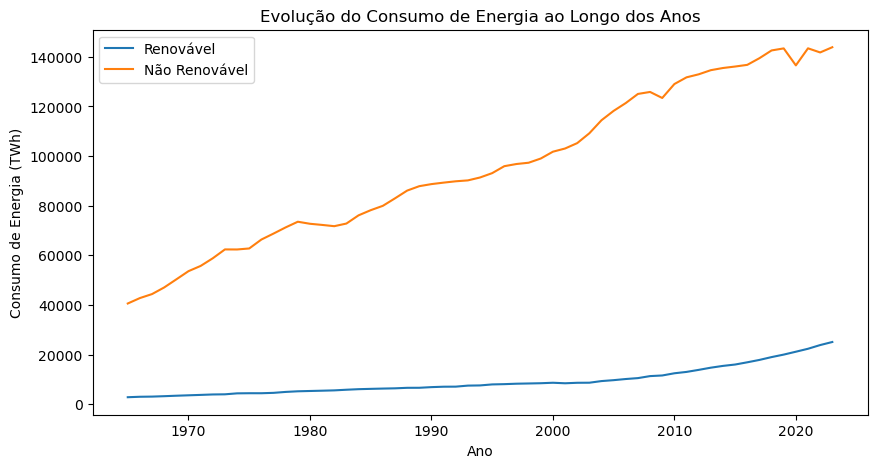

In [3]:
#Como o consumo total de energia (renovável e não renovável) mudou ao longo dos anos?

base_continente.groupby('ano')[['energia_renovavel', 'energia_nao_renovavel']].sum().plot(figsize=(10,5))
plt.title('Evolução do Consumo de Energia ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Consumo de Energia (TWh)')
plt.legend(['Renovável', 'Não Renovável'])
plt.show()

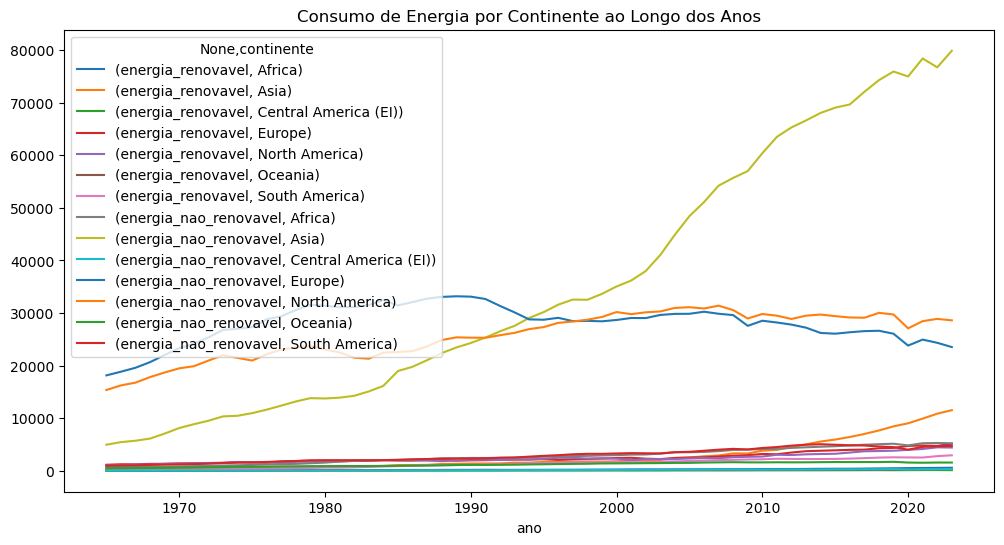

In [4]:
#Como os diferentes continentes evoluíram no consumo de energia?

base_continente.groupby(['ano', 'continente'])[['energia_renovavel', 'energia_nao_renovavel']].sum().unstack().plot(figsize=(12,6))
plt.title('Consumo de Energia por Continente ao Longo dos Anos')
plt.show()


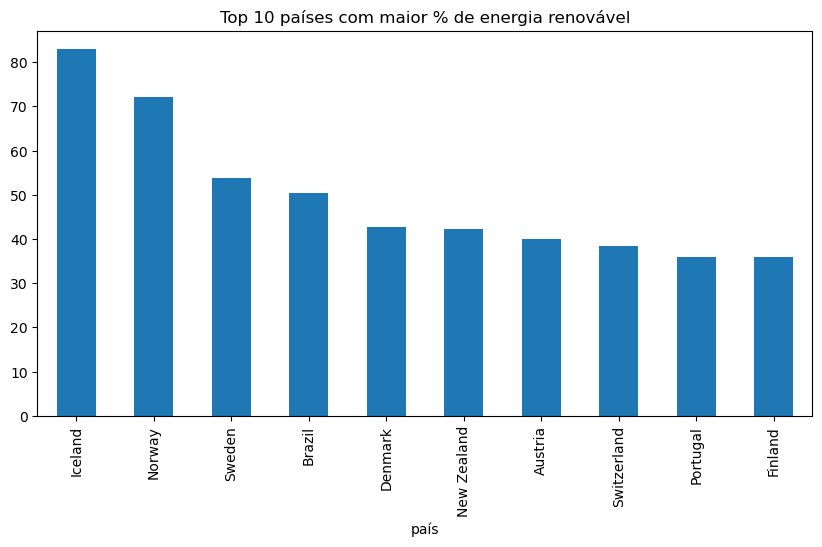

In [5]:
#Quais países mais aumentaram a participação de energia renovável nos últimos anos?

base_pais['perc_renovavel'] = base_pais['energia_renovavel'] / (base_pais['energia_renovavel'] + base_pais['energia_nao_renovavel']) * 100
top_paises = base_pais.groupby('país')['perc_renovavel'].last().sort_values(ascending=False).head(10)
top_paises.plot(kind='bar', figsize=(10,5), title="Top 10 países com maior % de energia renovável")
plt.show()


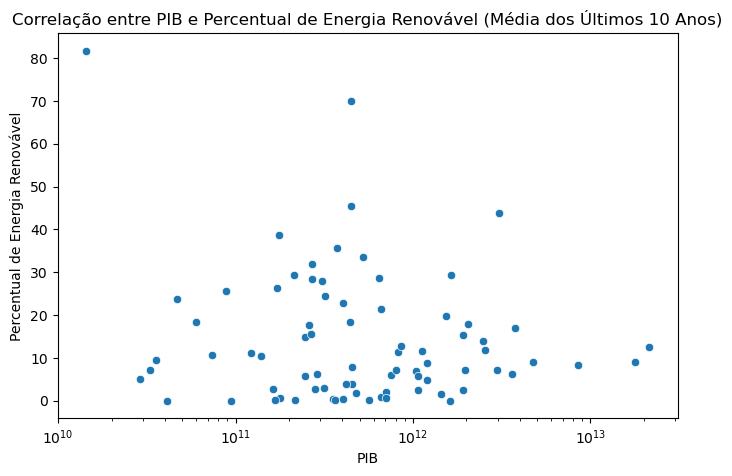

In [6]:
maior_ano = base_pais["ano"].max()
range_anos = range(maior_ano - 10, maior_ano)
base_ultimos_10_anos = base_pais[base_pais["ano"].isin(range_anos)]
media_pais = base_ultimos_10_anos.groupby("país")[["perc_renovavel", "pib"]].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=media_pais, x="pib", y="perc_renovavel")
plt.xscale("log")
plt.title("Correlação entre PIB e Percentual de Energia Renovável (Média dos Últimos 10 Anos)")
plt.xlabel("PIB")
plt.ylabel("Percentual de Energia Renovável")
plt.show()


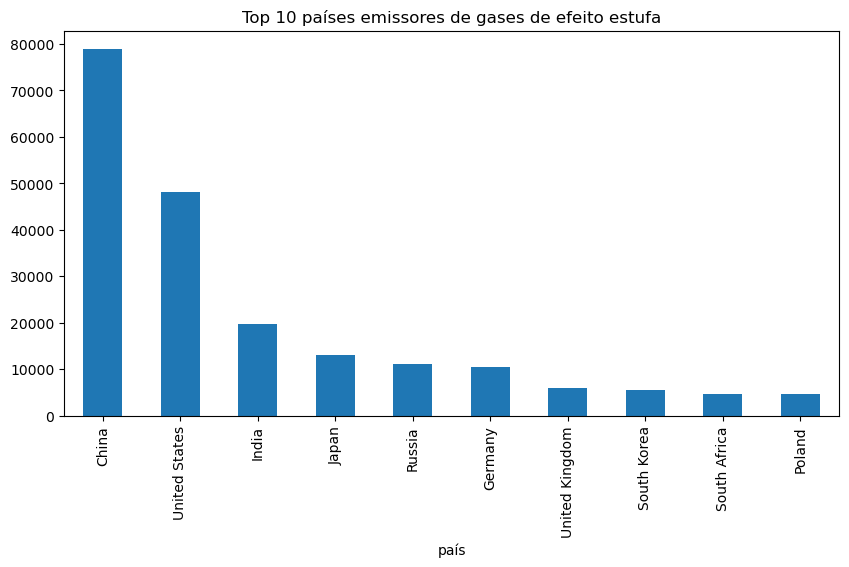

In [7]:
#Quais países têm as maiores emissões de CO₂ e como isso se relaciona com o consumo de energia?

top_emissores = base_pais.groupby('país')['emissões_gases_efeito_estufa'].sum().sort_values(ascending=False).head(10)
top_emissores.plot(kind='bar', figsize=(10,5), title="Top 10 países emissores de gases de efeito estufa")
plt.show()

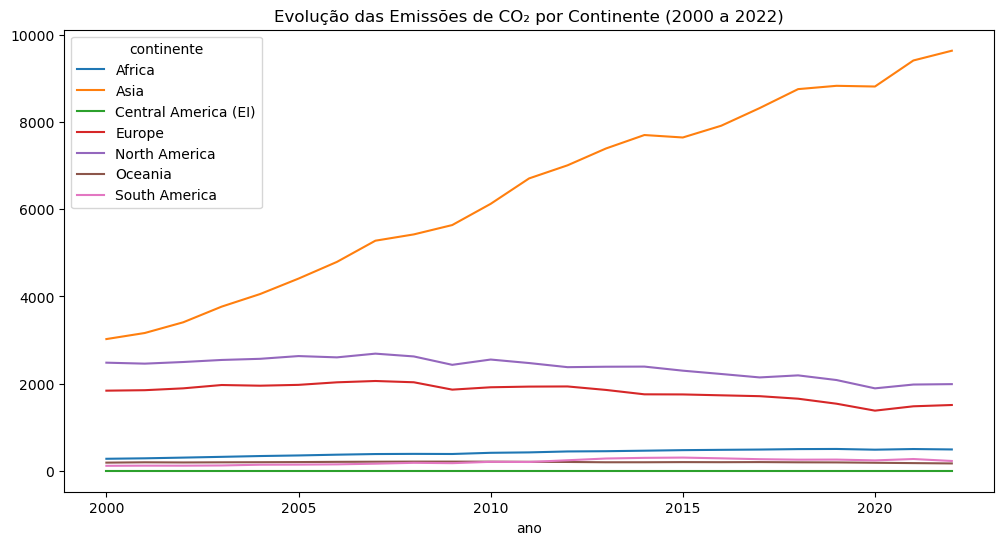

In [8]:
#Qual continente mais reduziu suas emissões ao longo do tempo?

#Temos registros apenas do ano 2000 a 2022, logo é necessário fazer o filtro apenas para esses anos
anos_validos = base_continente[base_continente['emissões_gases_efeito_estufa'].notna()]['ano'].unique()
primeiro_ano_com_registro = min(anos_validos)
ultimo_ano_com_registro = max(anos_validos)
base_filtrada = base_continente[base_continente['ano'].between(primeiro_ano_com_registro, ultimo_ano_com_registro)]

# Criar o gráfico
base_filtrada.groupby(['ano', 'continente'])['emissões_gases_efeito_estufa'].sum().unstack().plot(figsize=(12, 6))
plt.title(f'Evolução das Emissões de CO₂ por Continente ({primeiro_ano_com_registro} a {ultimo_ano_com_registro})')
plt.show()


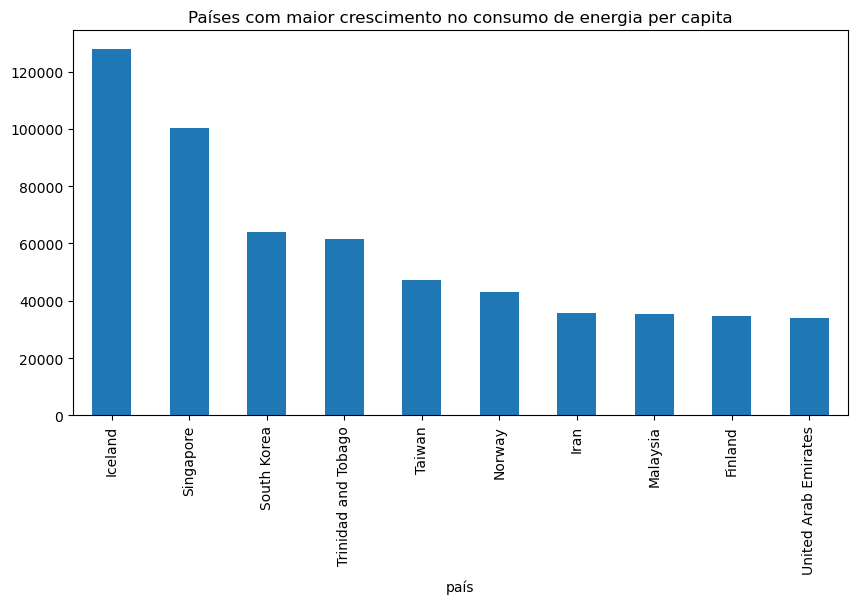

In [9]:
#Países com maior crescimento no consumo de energia:
variacao = base_pais.groupby('país')['energia_per_capita'].last() - base_pais.groupby('país')['energia_per_capita'].first()
variacao.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10,5), title="Países com maior crescimento no consumo de energia per capita")
plt.show()


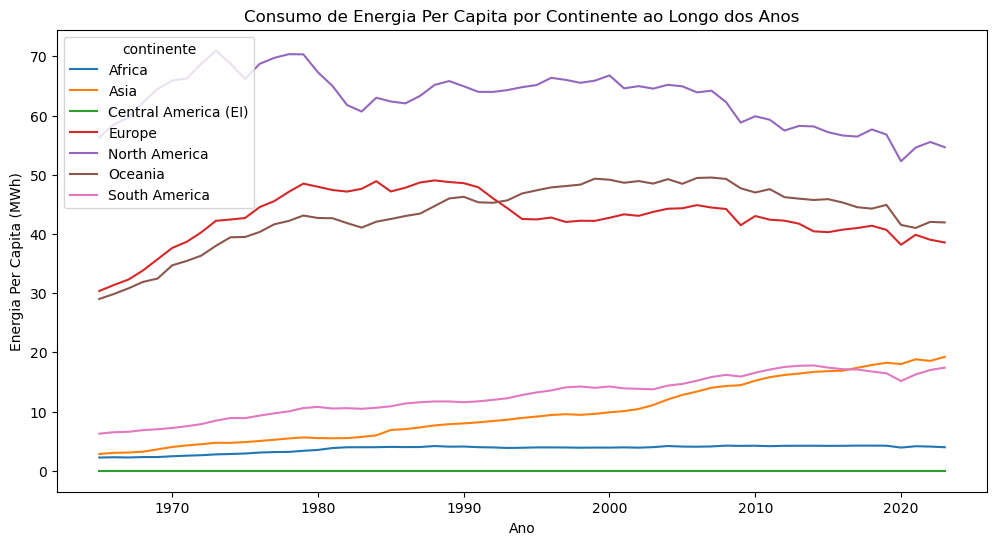

In [10]:
#Convertendo TWH para MWh para melhor apresentação do valor per capita
# 1 TWh = 1.000.000 MWh 
base_continente["energia_per_capita"] =  (( base_continente["energia_renovavel"] + base_continente["energia_nao_renovavel"]) * 1000000) / base_continente["população"]
energia_per_capita = base_continente.groupby(['ano', 'continente'])["energia_per_capita"].sum().unstack()

energia_per_capita.plot(figsize=(12, 6))
plt.title('Consumo de Energia Per Capita por Continente ao Longo dos Anos')
plt.ylabel('Energia Per Capita (MWh)')
plt.xlabel('Ano')
plt.show()

In [11]:
#Função para realizar contagem de outliers 
def contar_outliers(grupo, coluna):
    Q1 = grupo[coluna].quantile(0.25)  # Primeiro quartil
    Q3 = grupo[coluna].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo interquartil
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Contar valores fora dos limites
    return ((grupo[coluna] < limite_inferior) | (grupo[coluna] > limite_superior)).sum()

C:\Users\noise\AppData\Local\Temp\ipykernel_27680\3211679800.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_grupo = base_pais.groupby('país').apply(contar_outliers, coluna='energia_nao_renovavel')


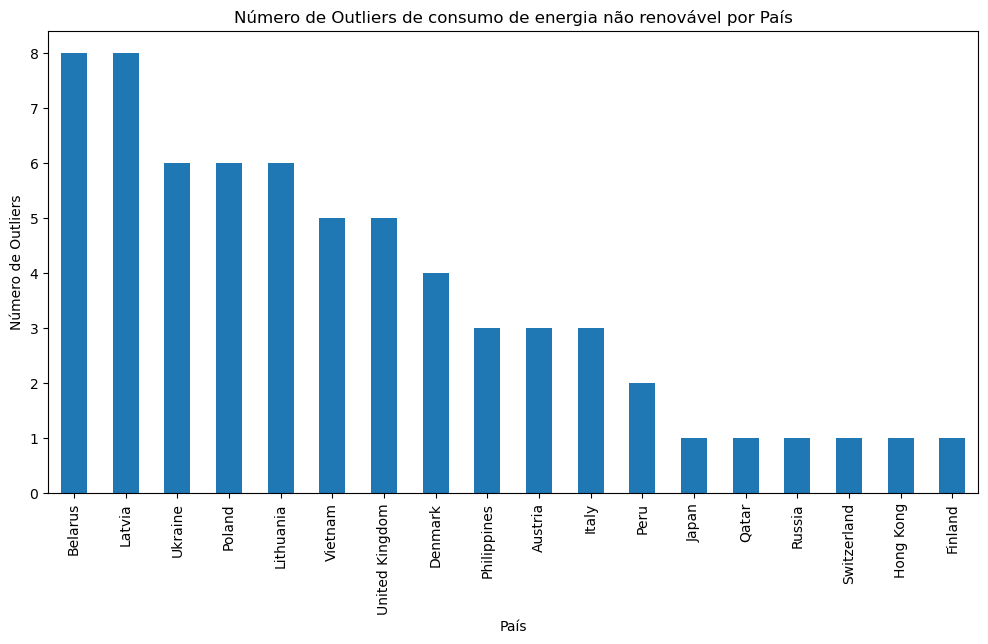

In [12]:
outliers_por_grupo = base_pais.groupby('país').apply(contar_outliers, coluna='energia_nao_renovavel')

outliers_por_grupo_filtrado = outliers_por_grupo[outliers_por_grupo > 0]

outliers_por_grupo_filtrado.sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 6), title="Número de Outliers de consumo de energia não renovável por País"
)
plt.xlabel("País")
plt.ylabel("Número de Outliers")
plt.show()

C:\Users\noise\AppData\Local\Temp\ipykernel_27680\1617305399.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_por_grupo = base_pais.groupby('país').apply(contar_outliers, coluna='energia_renovavel')


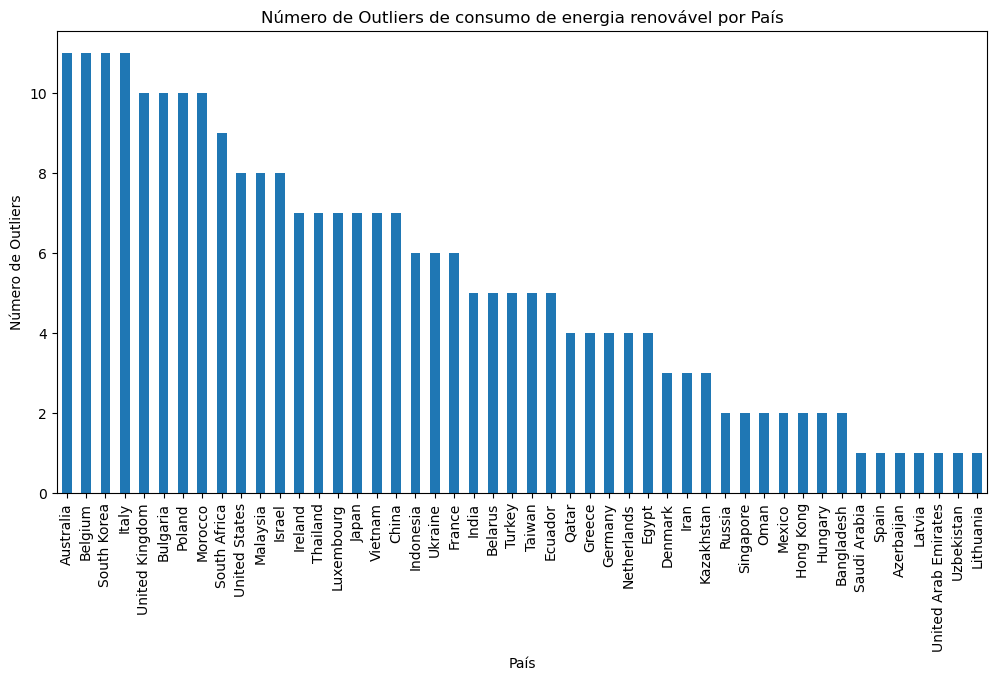

In [13]:
outliers_por_grupo = base_pais.groupby('país').apply(contar_outliers, coluna='energia_renovavel')

outliers_por_grupo_filtrado = outliers_por_grupo[outliers_por_grupo > 0]

outliers_por_grupo_filtrado.sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 6), title="Número de Outliers de consumo de energia renovável por País"
)
plt.xlabel("País")
plt.ylabel("Número de Outliers")
plt.show()

In [14]:
#Quantidade de Outliers sem agrupamento no dataframe de pais
outliers_pais_renovavel = contar_outliers(base_pais, 'energia_renovavel')
outliers_pais_nao_renovavel = contar_outliers(base_pais, 'energia_nao_renovavel')
print("Quantida de de outliers no dataframe de paises")
print(f"Energia renovável: {outliers_pais_renovavel}")
print(f"Energia não renovável: {outliers_pais_nao_renovavel}")

#Quantidade de Outliers sem agrupamento no dataframe de pais
outliers_continente_renovavel = contar_outliers(base_continente, 'energia_renovavel')
outliers_continente_nao_renovavel = contar_outliers(base_continente, 'energia_nao_renovavel')
print("Quantida de de outliers no dataframe de continentes")
print(f"Eenergia renovável: {outliers_continente_renovavel}")
print(f"Energia não renovável: {outliers_continente_nao_renovavel}")



Quantida de de outliers no dataframe de paises
Energia renovável: 483
Energia não renovável: 450
Quantida de de outliers no dataframe de continentes
Eenergia renovável: 12
Energia não renovável: 12


<Figure size 1400x800 with 0 Axes>

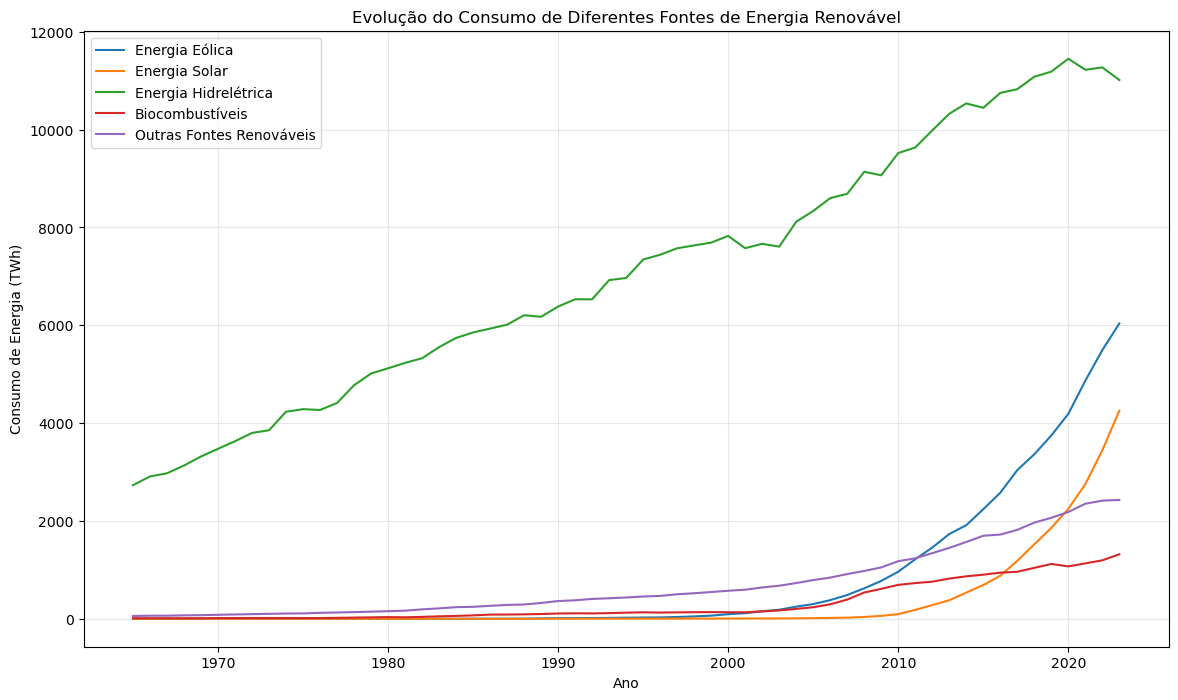

In [20]:
#Evolução das diferentes fontes de energia renovável ao longo do tempo

renovaveis_por_ano = base_continente.groupby('ano')[[
    'consumo_eólica',
    'consumo_solar',
    'consumo_hidrelétrica',
    'consumo_biocombustível',
    'consumo_outras_renováveis'
]].sum()

plt.figure(figsize=(14, 8))
renovaveis_por_ano.plot(figsize=(14, 8))

plt.title('Evolução do Consumo de Diferentes Fontes de Energia Renovável')
plt.xlabel('Ano')
plt.ylabel('Consumo de Energia (TWh)')
plt.grid(True, alpha=0.3)

plt.legend([
    'Energia Eólica', 
    'Energia Solar', 
    'Energia Hidrelétrica', 
    'Biocombustíveis', 
    'Outras Fontes Renováveis'
], loc='upper left')

plt.show()